# Data Analytics I: Assignment 2

### Mid Submission Report

- [X] Extracted and Cleaned Data
- [X] AOI Implementation
- [X] AOI Visualisations

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Extracting data from csv

In [2]:
def extract_data(file):
    data = pd.read_csv(file)
    return data

data = extract_data('Electric_Vehicle_Data.csv')

In [3]:
data.columns

Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')

Using only the relevant columns

In [4]:

data_reduced = data[
    [
        "Make",
        "Model",
        "Electric Vehicle Type",
        "Electric Range",
        "Base MSRP",
        "Model Year",
        "State",
        "Clean Alternative Fuel Vehicle (CAFV) Eligibility",
    ]
]

In [5]:
data_reduced["Electric Range"].value_counts()
data_reduced["Base MSRP"].value_counts()

0         178146
69900       1346
31950        382
52900        221
32250        134
59900        130
54950        129
39995        111
36900        104
44100         94
45600         82
64950         82
33950         74
34995         66
52650         65
36800         54
55700         51
53400         38
81100         22
98950         20
110950        20
90700         19
75095         14
102000        11
184400        10
43700          9
89100          8
109000         7
91250          5
32995          3
845000         1
Name: Base MSRP, dtype: int64

Filling up zero values in `Electric Range` and `Base MSRP` columns:

- Each zero has been replaced with the mean of non-zero values from rows with the same `Make` and `Model`.

- If there are no non-zero values for the specific `Make` and `Model`, the zero has been replaced with the median of non-zero values for the same `Make`.

- If neither group exists, it has been replaced with the overall median of non-zero values in the entire column.

All replacement values are rounded to the nearest integer to maintain consistency in the data.

In [6]:
def replace_zeros_with_mean(df, group_columns, target_column):
    overall_median = df[df[target_column] != 0][target_column].median()

    mean_make_model = (
        df[df[target_column] != 0]
        .groupby(group_columns)[target_column]
        .mean()
        .reset_index()
    )

    median_make = (
        df[df[target_column] != 0]
        .groupby(group_columns[0])[target_column]
        .median()
        .reset_index()
    )

    df = df.merge(
        mean_make_model, on=group_columns, how="left", suffixes=("", "_mean_make_model")
    )
    df = df.merge(
        median_make, on=group_columns[0], how="left", suffixes=("", "_median_make")
    )

    df[target_column] = df.apply(
        lambda row: (
            round(row[f"{target_column}_mean_make_model"])
            if row[target_column] == 0
            and not pd.isna(row[f"{target_column}_mean_make_model"])
            else (
                round(row[f"{target_column}_median_make"])
                if row[target_column] == 0
                and not pd.isna(row[f"{target_column}_median_make"])
                else (
                    round(overall_median)
                    if row[target_column] == 0
                    else round(row[target_column])
                )
            )
        ),
        axis=1,
    )

    df = df.drop(
        columns=[f"{target_column}_mean_make_model", f"{target_column}_median_make"]
    )

    return df

In [7]:
data_reduced = replace_zeros_with_mean(
    data_reduced, ["Make", "Model"], "Electric Range"
)
data_reduced = replace_zeros_with_mean(data_reduced, ["Make", "Model"], "Base MSRP")


data_reduced["Electric Range"].value_counts()
data_reduced["Base MSRP"].value_counts()

59900     74630
69900     74387
31950      7431
53025      6782
69019      6255
39995      3059
52900      2808
64950      1480
81100      1025
34995       838
36900       809
75095       434
44745       275
32250       134
184400      132
54950       129
54349       123
102000      112
44100        94
45600        82
33950        74
52650        65
36866        62
36800        54
55700        51
53400        38
110950       20
98950        20
90700        19
43700         9
89100         8
109000        7
91250         5
32855         3
32995         3
845000        1
Name: Base MSRP, dtype: int64

In [8]:
data_reduced.head()

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State,Clean Alternative Fuel Vehicle (CAFV) Eligibility
0,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),16,59900,2017,WA,Not eligible due to low battery range
1,AUDI,A3,Plug-in Hybrid Electric Vehicle (PHEV),16,59900,2018,WA,Not eligible due to low battery range
2,TESLA,MODEL S,Battery Electric Vehicle (BEV),210,69019,2017,WA,Clean Alternative Fuel Vehicle Eligible
3,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),25,59900,2021,WA,Not eligible due to low battery range
4,TESLA,MODEL 3,Battery Electric Vehicle (BEV),308,69900,2020,WA,Clean Alternative Fuel Vehicle Eligible


Concept Hierarchy

In [9]:
def create_concept_hierarchy(data):
    concept_hierarchy = {}

    makes = data['Make'].unique()
    concept_hierarchy['Make'] = {make: make for make in makes}

    concept_hierarchy['Electric Vehicle Type'] = {
        'Battery Electric Vehicle (BEV)': 'FullElectric',
        'Plug-in Hybrid Electric Vehicle (PHEV)': 'HybridElectric'
    }

    concept_hierarchy['Electric Range'] = lambda x: 'LongRange' if x > 200 else ('MediumRange' if x > 100 else 'ShortRange')

    concept_hierarchy['Base MSRP'] = lambda x: 'HighEnd' if x > 50000 else ('MidRange' if x > 30000 else 'Affordable')

    concept_hierarchy['Model Year'] = lambda x: str(x // 10 * 10) + 's'  # Generalize to decades

    regions = {
        'West': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'CO', 'AZ', 'NM'],
        'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH'],
        'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL'],
        'Northeast': ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'PA', 'NJ', 'DE', 'MD', 'DC']
    }
    concept_hierarchy['State'] = {state: region for region, states in regions.items() for state in states}

    concept_hierarchy['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = {
        'Clean Alternative Fuel Vehicle (CAFV) Eligible': 'Eligible',
        'Eligibility unknown as battery range has not been researched': 'Unknown',
        'Not eligible': 'NotEligible'
    }

    return concept_hierarchy

hierarchy = create_concept_hierarchy(data_reduced)


In [10]:
for attribute, mapping in hierarchy.items():
    print(f"\n{attribute}:")
    if callable(mapping):
        print(f"  Custom function: {mapping.__name__}")
    else:
        for key, value in list(mapping.items())[:5]:
            print(f"  {key}: {value}")
        if len(mapping) > 5:
            print(f"  ... and {len(mapping) - 5} more")


Make:
  AUDI: AUDI
  TESLA: TESLA
  JEEP: JEEP
  CHEVROLET: CHEVROLET
  KIA: KIA
  ... and 35 more

Electric Vehicle Type:
  Battery Electric Vehicle (BEV): FullElectric
  Plug-in Hybrid Electric Vehicle (PHEV): HybridElectric

Electric Range:
  Custom function: <lambda>

Base MSRP:
  Custom function: <lambda>

Model Year:
  Custom function: <lambda>

State:
  WA: West
  OR: West
  CA: West
  NV: West
  ID: West
  ... and 44 more

Clean Alternative Fuel Vehicle (CAFV) Eligibility:
  Clean Alternative Fuel Vehicle (CAFV) Eligible: Eligible
  Eligibility unknown as battery range has not been researched: Unknown
  Not eligible: NotEligible


Generalising

In [11]:
def generalize_attributes(data, concept_hierarchy):
    generalized_data = data.copy()
    for column in data.columns:
        if column in concept_hierarchy:
            generalized_data[column] = data[column].map(concept_hierarchy[column])
    print("Size after generalization:", len(generalized_data))

    return generalized_data

generalized_data = generalize_attributes(data_reduced, hierarchy)

Size after generalization: 181458


In [12]:
generalized_data.head()

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State,Clean Alternative Fuel Vehicle (CAFV) Eligibility
0,AUDI,A3,HybridElectric,ShortRange,HighEnd,2010s,West,NaN
1,AUDI,A3,HybridElectric,ShortRange,HighEnd,2010s,West,NaN
2,TESLA,MODEL S,FullElectric,LongRange,HighEnd,2010s,West,NaN
3,JEEP,WRANGLER,HybridElectric,ShortRange,HighEnd,2020s,West,NaN
4,TESLA,MODEL 3,FullElectric,LongRange,HighEnd,2020s,West,NaN


Group-by

In [13]:
grouped_data = (
    generalized_data.groupby(
        [
            "Make",
            "Model",
            "Electric Vehicle Type",
            "Electric Range",
            "Base MSRP",
            "Model Year",
            "State",
            "Clean Alternative Fuel Vehicle (CAFV) Eligibility",
        ]
    )
    .size()
    .reset_index(name="Count")
)
grouped_data = grouped_data.sort_values(by="Count", ascending=False)
grouped_data.head()

,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Model Year,State,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Count
84,TESLA,MODEL Y,FullElectric,LongRange,HighEnd,2020s,West,Unknown,34598
76,TESLA,MODEL 3,FullElectric,LongRange,HighEnd,2020s,West,Unknown,16323
89,VOLKSWAGEN,ID.4,FullElectric,MediumRange,HighEnd,2020s,West,Unknown,4086
29,FORD,MUSTANG MACH-E,FullElectric,ShortRange,HighEnd,2020s,West,Unknown,3483
62,NISSAN,LEAF,FullElectric,MediumRange,HighEnd,2020s,West,Unknown,2601


Specific Grouping and Visualising

In [14]:
grouped_data_make = generalized_data.groupby(['Make']).size().reset_index(name='Count')
grouped_data_make = grouped_data_make.sort_values(by=['Count'], ascending=False)
grouped_data_make.head()

,Make,Count
34,TESLA,80819
27,NISSAN,14037
6,CHEVROLET,13864
11,FORD,9527
4,BMW,7680


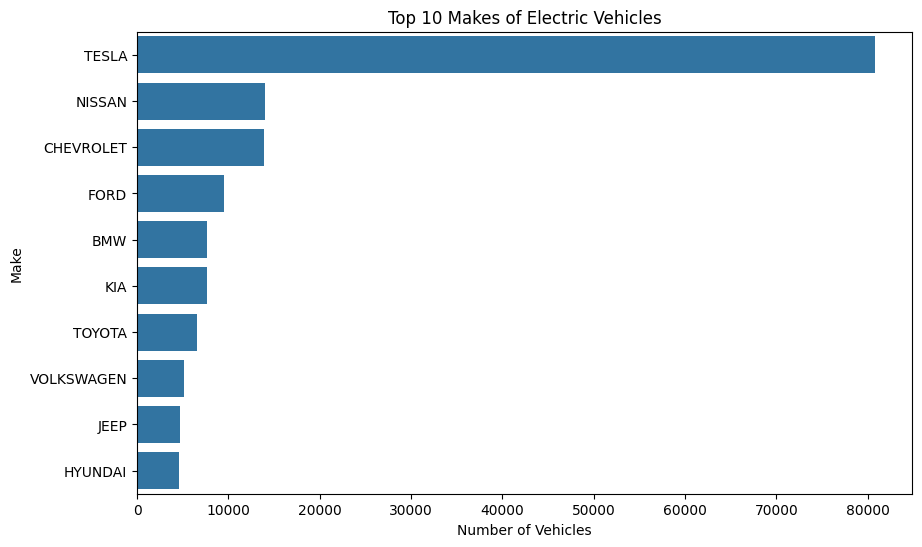

In [15]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Make', data=grouped_data_make.head(10))
plt.title('Top 10 Makes of Electric Vehicles')
plt.xlabel('Number of Vehicles')
plt.ylabel('Make')
plt.show()


In [16]:
grouped_data_type = generalized_data.groupby(['Electric Vehicle Type', 'State']).size().reset_index(name='Count')
grouped_data_type = grouped_data_type.sort_values(by=['Count'], ascending=False)
grouped_data_type.head()


,Electric Vehicle Type,State,Count
3,FullElectric,West,141813
7,HybridElectric,West,39401
2,FullElectric,South,84
6,HybridElectric,South,46
1,FullElectric,Northeast,41


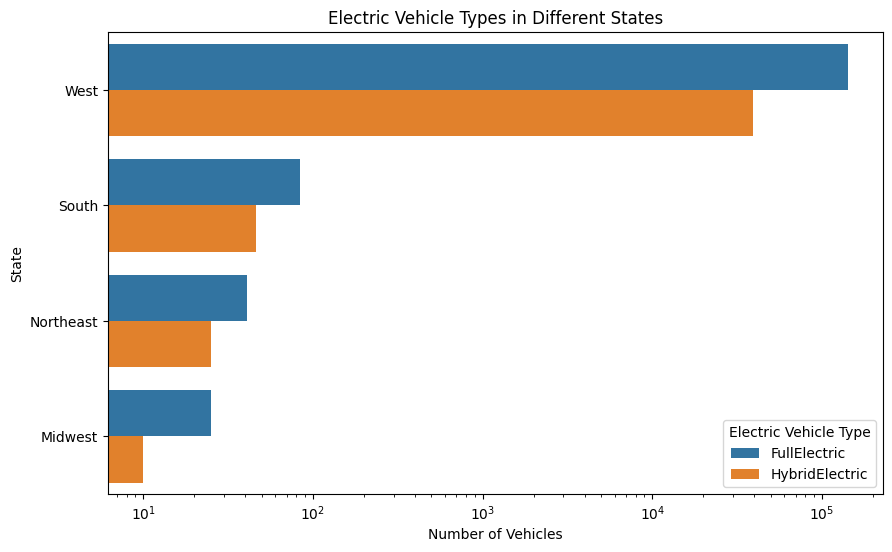

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='State', hue='Electric Vehicle Type', data=grouped_data_type)
plt.title('Electric Vehicle Types in Different States')
plt.xlabel('Number of Vehicles')
plt.ylabel('State')
plt.xscale('log')
plt.show()


In [18]:
grouped_data_range = generalized_data.groupby(['Electric Range', 'Base MSRP']).size().reset_index(name='Count')
grouped_data_range = grouped_data_range.sort_values(by=['Count'], ascending=False)
grouped_data_range.head()

,Electric Range,Base MSRP,Count
0,LongRange,HighEnd,89451
4,ShortRange,HighEnd,65559
2,MediumRange,HighEnd,13521
5,ShortRange,MidRange,10038
3,MediumRange,MidRange,2048


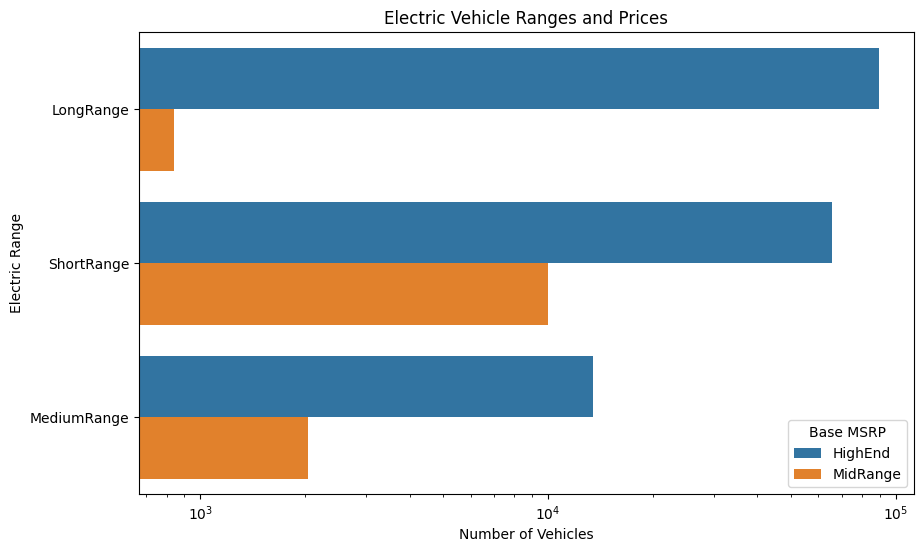

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Electric Range', hue='Base MSRP', data=grouped_data_range)
plt.title('Electric Vehicle Ranges and Prices')
plt.xlabel('Number of Vehicles')
plt.ylabel('Electric Range')
plt.xscale('log')
plt.show()


In [20]:
grouped_data_year = generalized_data.groupby(['Model Year', 'Make', 'Model']).size().reset_index(name='Count')
grouped_data_year = grouped_data_year.sort_values(by=['Count'], ascending=False)
grouped_data_year.head()


,Model Year,Make,Model,Count
164,2020s,TESLA,MODEL Y,37007
161,2020s,TESLA,MODEL 3,19953
52,2010s,TESLA,MODEL 3,10197
44,2010s,NISSAN,LEAF,10121
53,2010s,TESLA,MODEL S,5588


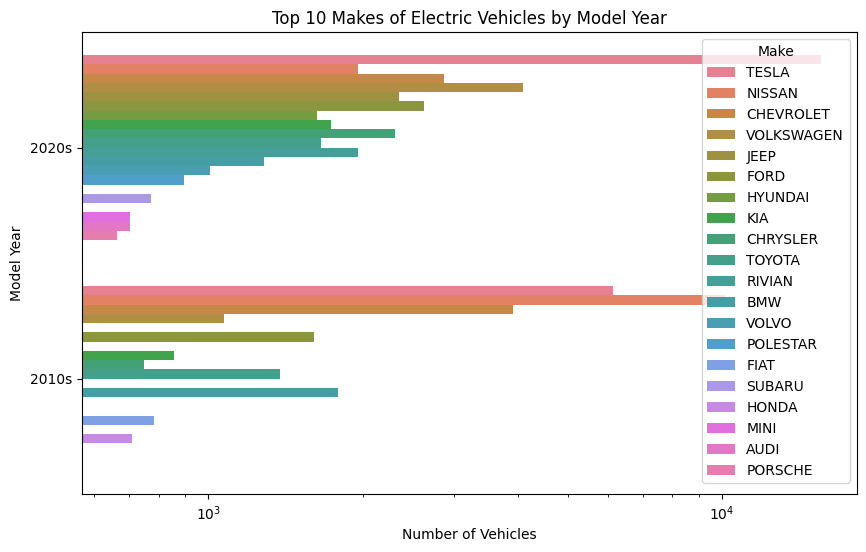

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Model Year', hue='Make', data=grouped_data_year.head(50), errorbar=None)
plt.title('Top 10 Makes of Electric Vehicles by Model Year')
plt.xlabel('Number of Vehicles')
plt.xscale('log')
plt.ylabel('Model Year')
plt.show()

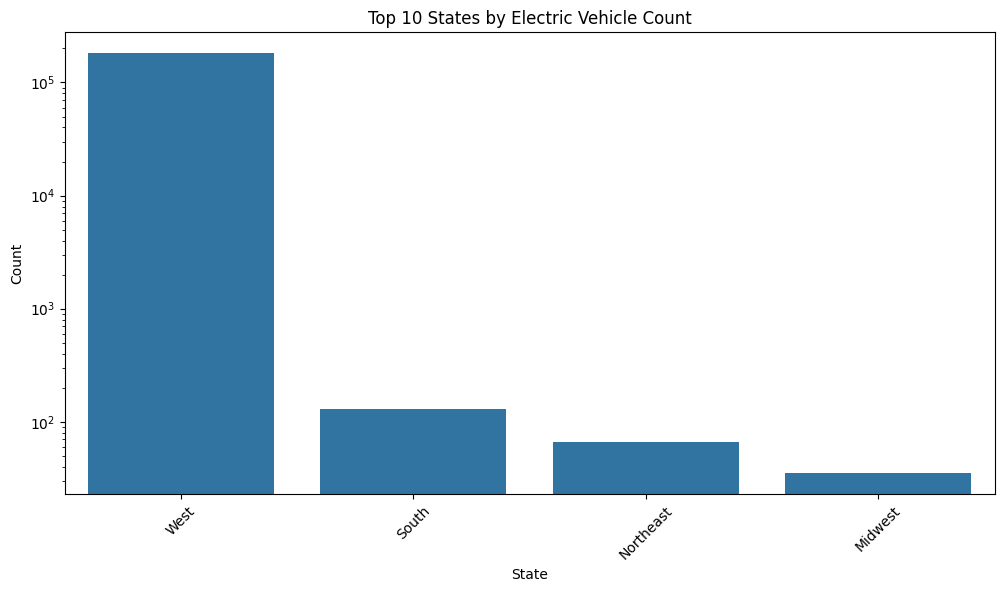

In [22]:
state_count = generalized_data.groupby('State').size().sort_values(ascending=False).reset_index(name='Count')
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Count', data=state_count.head(10))
plt.title('Top 10 States by Electric Vehicle Count')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()